# Klasifikacija slika koriscenjem CNN arhitekture

*   **Dataset:** Flowers
*   **Arhitektura:** ResNet-50 with additional dense layers
*   **Pretprocesiranje:** Normalization, rotation
*   **Optimizator:** SGD



Povezivanje sa drive-om



In [2]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append("drive/MyDrive/Colab Notebooks/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Ucitavanje potrebnih biblioteka

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl

from keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomFlip, RandomZoom
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.metrics import Precision

np.random.seed(42) #generator slucajnih brojeva
tf.random.set_seed(42)

Ucitavanje podataka

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
directory = "drive/My Drive/Colab Notebooks/datasets/flowers/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle = True,
                                             batch_size = BATCH_SIZE,
                                             image_size = IMG_SIZE,
                                             validation_split = 0.2,
                                             subset = "training",
                                             seed = 42)

validation_dataset = image_dataset_from_directory(directory,
                                             shuffle = True,
                                             batch_size = BATCH_SIZE,
                                             image_size = IMG_SIZE,
                                             validation_split = 0.2,
                                             subset = "validation",
                                             seed = 42)

Found 2073 files belonging to 5 classes.
Using 1659 files for training.
Found 2073 files belonging to 5 classes.
Using 414 files for validation.


Pronadjene klase, ima ih 5: daisy(bela rada), dandelion(maslacak), roses(ruze), sunflowers(suncokreti), tulips(lale)

In [5]:
class_names = train_dataset.class_names

In [5]:
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

One hot enkodiranje

In [6]:
def one_hot_encode_dataset(dataset, num_classes):
    encoded_dataset = dataset.map(lambda x, y: (x, tf.one_hot(y, 5)))
    return encoded_dataset

In [7]:
train_dataset = one_hot_encode_dataset(train_dataset, 5)
validation_dataset = one_hot_encode_dataset(validation_dataset, 5)

Prikaz nekih slika iz dataset-a

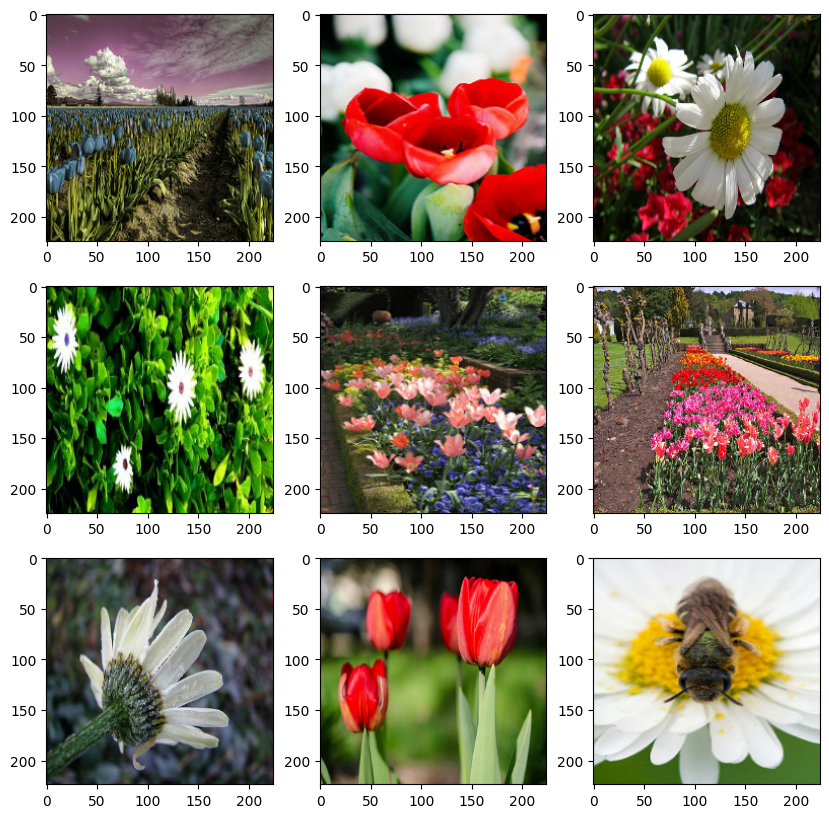

In [ ]:
plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))

Data Augmentation (Rotiranje) - obavezno

In [8]:
def data_augmenter():
  data_augmenten = tf.keras.Sequential()
  data_augmenten.add(RandomFlip("horizontal"))
  data_augmenten.add(RandomFlip("vertical"))
  data_augmenten.add(RandomZoom(0.2))
  data_augmenten.add(RandomRotation(0.2))

  return data_augmenten

In [9]:
data_augmentation = data_augmenter()

Ucitavanje pretreniranog ResNet50 modela

In [10]:
weights_resnet50 = 'drive/My Drive/Colab Notebooks/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [11]:
base_model = tf.keras.applications.ResNet50(input_shape = (224,224,3), include_top = False, pooling='avg', weights = weights_resnet50)

In [12]:
len(base_model.layers) #proveravam broj slojeva

176

Kreiranje modela

In [11]:
from keras.applications import ResNet50

In [28]:
def flower_model(image_shape = IMG_SIZE, classes = 5, data_augmentation = data_augmenter()):
  input_shape = image_shape + (3,)
  base_model = tf.keras.applications.ResNet50(input_shape = input_shape, include_top = False, pooling='avg', weights = weights_resnet50)

  base_model.trainable = False

  inputs = tf.keras.Input(shape = input_shape)
  x = data_augmentation(inputs) #augmentacija
  x = preprocess_input(x) #normalizacija
  x = base_model(x, training = False)

  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dense(2048, activation="relu")(x)
  x = tf.keras.layers.Dropout(rate=0.5)(x) #nakon svakog gustog sloja cemo iskljuciti 50% jedinica da ne bi doslo do overfittinga
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dense(1024, activation="relu")(x)
  x = tf.keras.layers.Dropout(rate=0.5)(x)
  x = tf.keras.layers.BatchNormalization()(x)

  predictions_layer = tf.keras.layers.Dense(classes, activation="softmax", kernel_initializer = glorot_uniform(seed = 0)) #prilagodjavamo poslednji sloj nasem dataset-u(5 klasa)
  outputs = predictions_layer(x)

  model = tf.keras.Model(inputs, outputs)

  return model

In [29]:
model = flower_model()

In [ ]:
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_18 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_4  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_4 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_11 (Flatten)        (None, 2048)              0  

Prvi pokusaj treniranja mreze sa parametrima lr=0.01, batch_size=32, epochs=10

In [14]:
model.compile(optimizer=SGD(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy', Precision(name='precision')])

In [ ]:
history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset, batch_size=32)

Epoch 1/10
52/52 [==============================] - 425s 8s/step - loss: 1.3011 - accuracy: 0.5220 - precision: 0.6062 - val_loss: 0.5840 - val_accuracy: 0.8551 - val_precision: 0.9263
Epoch 2/10
52/52 [==============================] - 398s 8s/step - loss: 0.7323 - accuracy: 0.7492 - precision: 0.8088 - val_loss: 0.4038 - val_accuracy: 0.8816 - val_precision: 0.9229
Epoch 3/10
52/52 [==============================] - 399s 8s/step - loss: 0.6000 - accuracy: 0.8053 - precision: 0.8437 - val_loss: 0.3441 - val_accuracy: 0.8961 - val_precision: 0.9117
Epoch 4/10
52/52 [==============================] - 388s 7s/step - loss: 0.5075 - accuracy: 0.8373 - precision: 0.8738 - val_loss: 0.3191 - val_accuracy: 0.8889 - val_precision: 0.9055
Epoch 5/10
52/52 [==============================] - 395s 8s/step - loss: 0.4666 - accuracy: 0.8403 - precision: 0.8662 - val_loss: 0.2995 - val_accuracy: 0.8986 - val_precision: 0.9069
Epoch 6/10
52/52 [==============================] - 390s 8s/step - loss: 0.

In [ ]:
model.evaluate(validation_dataset)

13/13 [==============================] - 93s 7s/step - loss: 0.2845 - accuracy: 0.9034 - precision: 0.9027


[0.28449833393096924, 0.9033816456794739, 0.9026764035224915]

<ipython-input-116-994ff48d67ef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns = {"loss" : "train", "val_loss" : "validation"}, inplace = True)
<ipython-input-116-994ff48d67ef>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns = {"accuracy" : "train", "val_accuracy" : "validation"}, inplace = True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

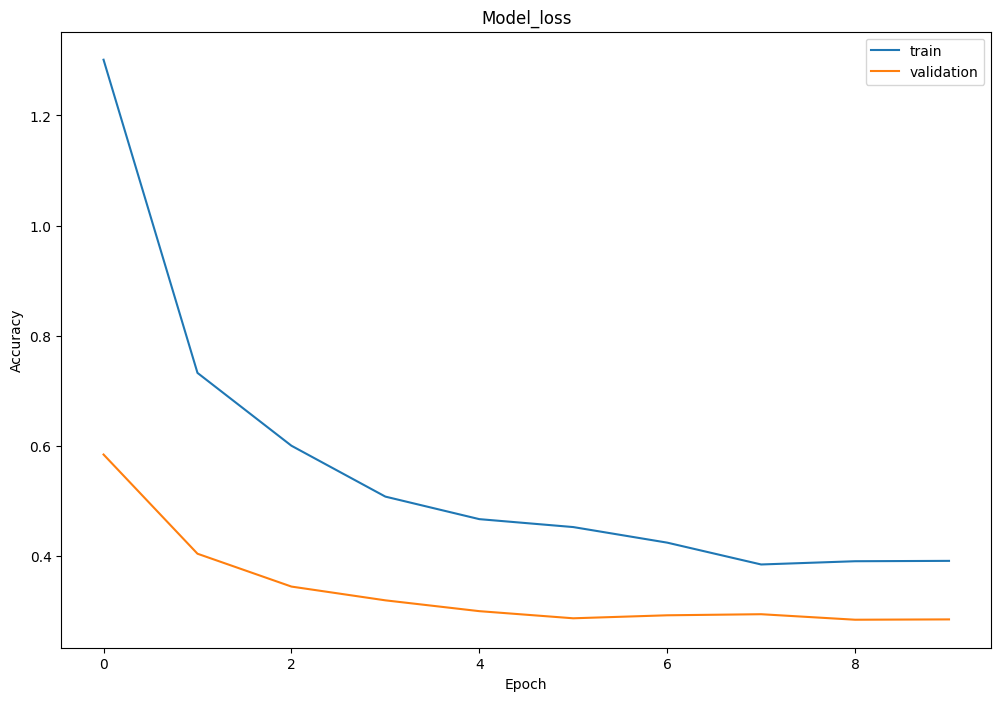

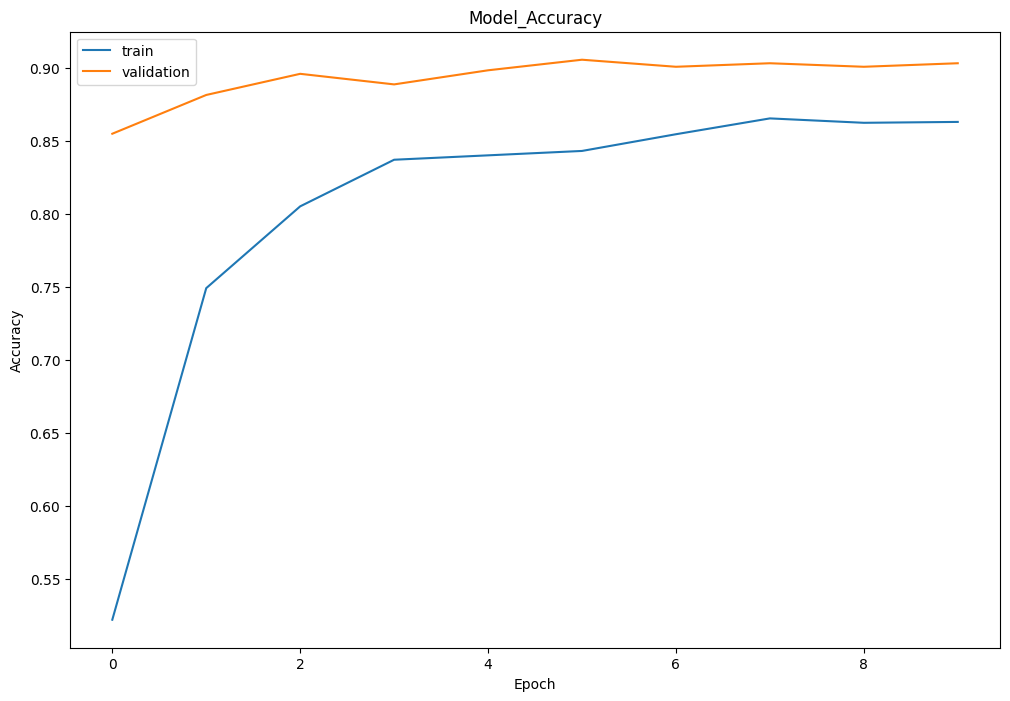

In [ ]:
df_loss_acc = pd.DataFrame(history.history)
df_loss = df_loss_acc[["loss", "val_loss"]]
df_loss.rename(columns = {"loss" : "train", "val_loss" : "validation"}, inplace = True)
df_acc = df_loss_acc[["accuracy", "val_accuracy"]]
df_acc.rename(columns = {"accuracy" : "train", "val_accuracy" : "validation"}, inplace = True)
df_loss.plot(title="Model_loss", figsize=(12, 8)).set(xlabel="Epoch", ylabel="Accuracy")
df_acc.plot(title="Model_Accuracy", figsize=(12, 8)).set(xlabel="Epoch", ylabel="Accuracy")

Drugi pokusaj treniranja mreze sa parametrima lr=0.02, batch_size=32, epochs=8

In [ ]:
model.compile(optimizer=SGD(learning_rate=0.02), loss='categorical_crossentropy', metrics=['accuracy', Precision(name='precision')])

In [ ]:
history = model.fit(train_dataset, epochs=8, validation_data=validation_dataset, batch_size=32)

Epoch 1/8
52/52 [==============================] - 513s 10s/step - loss: 1.0424 - accuracy: 0.6462 - precision: 0.7375 - val_loss: 0.4332 - val_accuracy: 0.8816 - val_precision: 0.9164
Epoch 2/8
52/52 [==============================] - 505s 10s/step - loss: 0.6055 - accuracy: 0.8029 - precision: 0.8447 - val_loss: 0.3468 - val_accuracy: 0.8889 - val_precision: 0.9070
Epoch 3/8
52/52 [==============================] - 501s 10s/step - loss: 0.4948 - accuracy: 0.8294 - precision: 0.8562 - val_loss: 0.3118 - val_accuracy: 0.8889 - val_precision: 0.8968
Epoch 4/8
52/52 [==============================] - 446s 9s/step - loss: 0.3874 - accuracy: 0.8686 - precision: 0.8876 - val_loss: 0.2991 - val_accuracy: 0.8937 - val_precision: 0.8995
Epoch 5/8
52/52 [==============================] - 503s 10s/step - loss: 0.4122 - accuracy: 0.8583 - precision: 0.8756 - val_loss: 0.2938 - val_accuracy: 0.8961 - val_precision: 0.9000
Epoch 6/8
52/52 [==============================] - 502s 10s/step - loss: 0.3

In [ ]:
model.evaluate(validation_dataset)

13/13 [==============================] - 89s 7s/step - loss: 0.2834 - accuracy: 0.8986 - precision: 0.9027


[0.2833755612373352, 0.8985507488250732, 0.9026764035224915]

<ipython-input-35-994ff48d67ef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns = {"loss" : "train", "val_loss" : "validation"}, inplace = True)
<ipython-input-35-994ff48d67ef>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns = {"accuracy" : "train", "val_accuracy" : "validation"}, inplace = True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

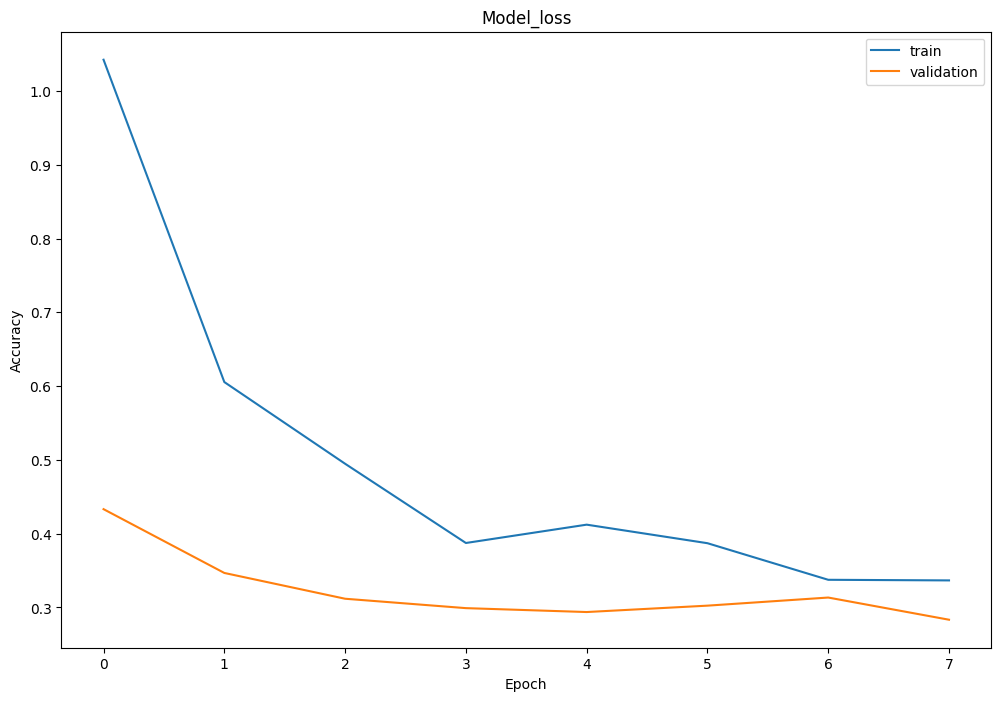

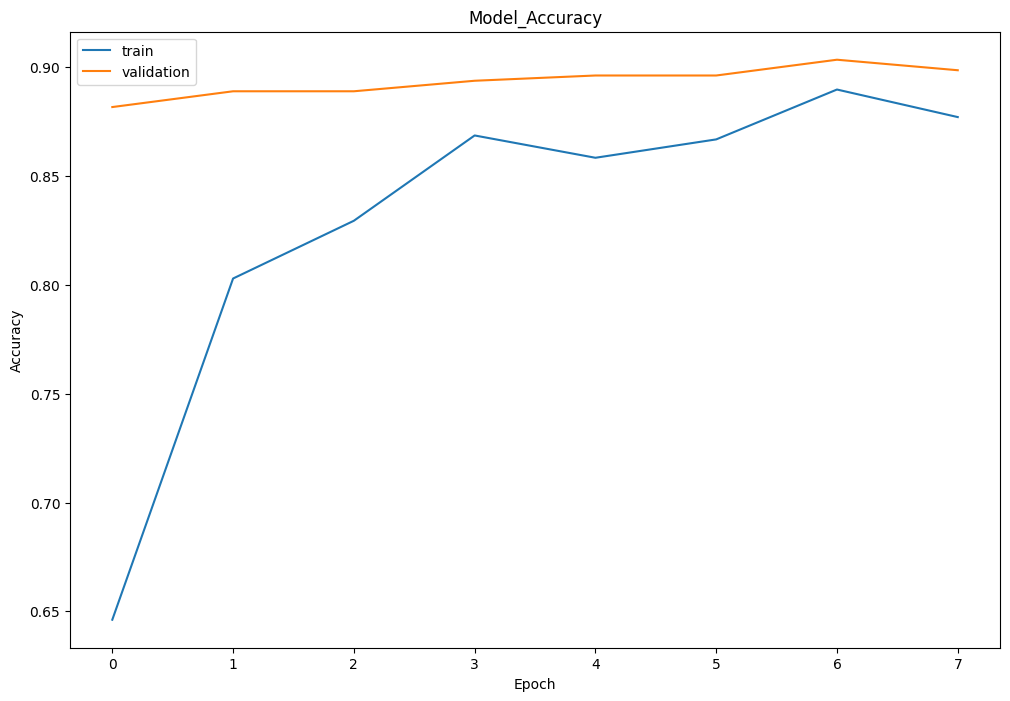

In [ ]:
df_loss_acc = pd.DataFrame(history.history)
df_loss = df_loss_acc[["loss", "val_loss"]]
df_loss.rename(columns = {"loss" : "train", "val_loss" : "validation"}, inplace = True)
df_acc = df_loss_acc[["accuracy", "val_accuracy"]]
df_acc.rename(columns = {"accuracy" : "train", "val_accuracy" : "validation"}, inplace = True)
df_loss.plot(title="Model_loss", figsize=(12, 8)).set(xlabel="Epoch", ylabel="Accuracy")
df_acc.plot(title="Model_Accuracy", figsize=(12, 8)).set(xlabel="Epoch", ylabel="Accuracy")

Treci pokusaj treniranja mreze sa parametrima lr=0.02, batch_size=64, epochs=8

In [24]:
model.compile(optimizer=SGD(learning_rate=0.02), loss='categorical_crossentropy', metrics=['accuracy', Precision(name='precision')])

In [25]:
history = model.fit(train_dataset, epochs=8, validation_data=validation_dataset, batch_size=64)

Epoch 1/8
52/52 [==============================] - 592s 10s/step - loss: 0.8942 - accuracy: 0.6835 - precision: 0.7726 - val_loss: 0.4328 - val_accuracy: 0.8671 - val_precision: 0.9162
Epoch 2/8
52/52 [==============================] - 514s 10s/step - loss: 0.5677 - accuracy: 0.8113 - precision: 0.8469 - val_loss: 0.3382 - val_accuracy: 0.9058 - val_precision: 0.9137
Epoch 3/8
52/52 [==============================] - 512s 10s/step - loss: 0.4662 - accuracy: 0.8403 - precision: 0.8715 - val_loss: 0.3102 - val_accuracy: 0.9010 - val_precision: 0.9111
Epoch 4/8
52/52 [==============================] - 513s 10s/step - loss: 0.4313 - accuracy: 0.8608 - precision: 0.8789 - val_loss: 0.2850 - val_accuracy: 0.9010 - val_precision: 0.9022
Epoch 5/8
52/52 [==============================] - 505s 10s/step - loss: 0.3860 - accuracy: 0.8740 - precision: 0.8853 - val_loss: 0.2853 - val_accuracy: 0.8961 - val_precision: 0.9027
Epoch 6/8
52/52 [==============================] - 509s 10s/step - loss: 0.

In [26]:
model.evaluate(validation_dataset)

13/13 [==============================] - 92s 7s/step - loss: 0.2915 - accuracy: 0.8865 - precision: 0.8924


[0.29146111011505127, 0.8864734172821045, 0.8924205303192139]

<ipython-input-27-181b6b83c712>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns = {"loss" : "train", "val_loss" : "validation"}, inplace = True)
<ipython-input-27-181b6b83c712>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns = {"accuracy" : "train", "val_accuracy" : "validation"}, inplace = True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

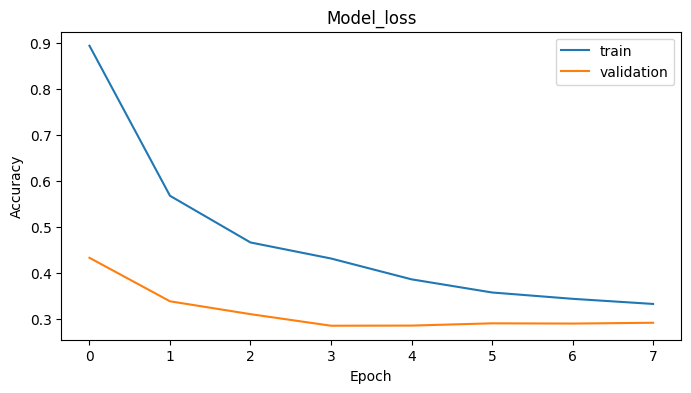

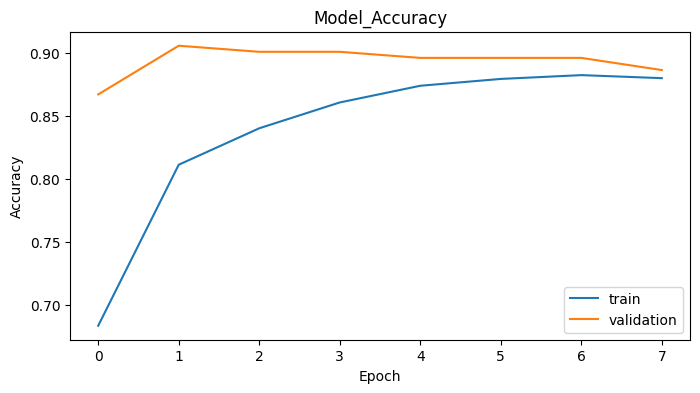

In [27]:
df_loss_acc = pd.DataFrame(history.history)
df_loss = df_loss_acc[["loss", "val_loss"]]
df_loss.rename(columns = {"loss" : "train", "val_loss" : "validation"}, inplace = True)
df_acc = df_loss_acc[["accuracy", "val_accuracy"]]
df_acc.rename(columns = {"accuracy" : "train", "val_accuracy" : "validation"}, inplace = True)
df_loss.plot(title="Model_loss", figsize=(8, 4)).set(xlabel="Epoch", ylabel="Accuracy")
df_acc.plot(title="Model_Accuracy", figsize=(8, 4)).set(xlabel="Epoch", ylabel="Accuracy")

Promena parametara tokom drugog i treceg treniranja nije dovela do poboljsanja rezultata, pa sam u model ubacila fine_tuning tehniku kako bih pokusala da poboljsam model

Zamrzavanje prvih 100 slojeva

In [34]:
def flower_model(image_shape = IMG_SIZE, classes = 5, data_augmentation = data_augmenter()):
  input_shape = image_shape + (3,)
  base_model = tf.keras.applications.ResNet50(input_shape = input_shape, include_top = False, pooling='avg', weights = weights_resnet50)

  #base_model.trainable = False

  #fine tuning
  base_model.trainable = True #ovo ce da trenira sve modele
  #prvih 100 layer-a necemo (od 176)
  fine_tune_at = 100
  for layer in base_model.layers[:fine_tune_at]: #na ovaj nacin neke layer-e zamrzavamo
    layer.trainable = None

  inputs = tf.keras.Input(shape = input_shape)
  x = data_augmentation(inputs) #rotiranje
  x = preprocess_input(x) #normalizacija
  x = base_model(x, training = False)

  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dense(2048, activation="relu")(x)
  x = tf.keras.layers.Dropout(rate=0.5)(x) #nakon svakog gustog sloja cemo iskljuciti 50% jedinica da ne bi doslo do overfittinga
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dense(1024, activation="relu")(x)
  x = tf.keras.layers.Dropout(rate=0.5)(x)
  x = tf.keras.layers.BatchNormalization()(x)

  predictions_layer = tf.keras.layers.Dense(classes, activation="softmax", kernel_initializer = glorot_uniform(seed = 0)) #prilagodjavamo poslednji sloj nasem dataset-u(5 klasa)
  outputs = predictions_layer(x)

  model = tf.keras.Model(inputs, outputs)

  return model

In [35]:
model = flower_model()

In [ ]:
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_17 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_3  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_3 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_10 (Flatten)        (None, 2048)              0  

In [36]:
model.compile(optimizer=SGD(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy', Precision(name='precision')])

In [37]:
history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset, batch_size=32)

Epoch 1/10
52/52 [==============================] - 911s 17s/step - loss: 0.9225 - accuracy: 0.6727 - precision: 0.7502 - val_loss: 1.9525 - val_accuracy: 0.5942 - val_precision: 0.6486
Epoch 2/10
52/52 [==============================] - 864s 17s/step - loss: 0.4288 - accuracy: 0.8541 - precision: 0.8729 - val_loss: 0.5736 - val_accuracy: 0.8720 - val_precision: 0.8853
Epoch 3/10
52/52 [==============================] - 850s 16s/step - loss: 0.3894 - accuracy: 0.8782 - precision: 0.8885 - val_loss: 0.4546 - val_accuracy: 0.8478 - val_precision: 0.8488
Epoch 4/10
52/52 [==============================] - 839s 16s/step - loss: 0.2866 - accuracy: 0.8945 - precision: 0.9047 - val_loss: 0.3375 - val_accuracy: 0.8841 - val_precision: 0.8859
Epoch 5/10
52/52 [==============================] - 782s 15s/step - loss: 0.2738 - accuracy: 0.9108 - precision: 0.9186 - val_loss: 0.3349 - val_accuracy: 0.8913 - val_precision: 0.8968
Epoch 6/10
52/52 [==============================] - 845s 16s/step - lo

Bilo je dovoljno 8 epoha da ne dodje do preucavanja modela

In [38]:
model.evaluate(validation_dataset)

13/13 [==============================] - 84s 6s/step - loss: 0.3429 - accuracy: 0.8937 - precision: 0.8954


[0.3429054617881775, 0.8937197923660278, 0.8953770995140076]

<ipython-input-39-181b6b83c712>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns = {"loss" : "train", "val_loss" : "validation"}, inplace = True)
<ipython-input-39-181b6b83c712>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns = {"accuracy" : "train", "val_accuracy" : "validation"}, inplace = True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

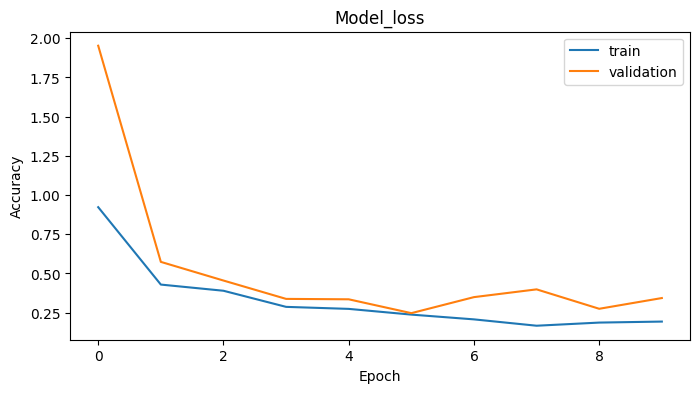

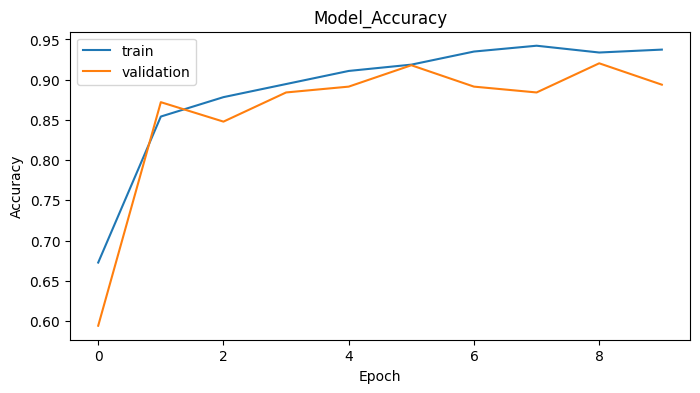

In [39]:
df_loss_acc = pd.DataFrame(history.history)
df_loss = df_loss_acc[["loss", "val_loss"]]
df_loss.rename(columns = {"loss" : "train", "val_loss" : "validation"}, inplace = True)
df_acc = df_loss_acc[["accuracy", "val_accuracy"]]
df_acc.rename(columns = {"accuracy" : "train", "val_accuracy" : "validation"}, inplace = True)
df_loss.plot(title="Model_loss", figsize=(8, 4)).set(xlabel="Epoch", ylabel="Accuracy")
df_acc.plot(title="Model_Accuracy", figsize=(8, 4)).set(xlabel="Epoch", ylabel="Accuracy")

Ovaj model nije sjajan ali je najbolji do sada, sa preciznoscu i tacnoscu ~89%